# Project: Wrangle and Analyze WeRateDogs twitter data

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

## Gather Data

In [3]:
# Read the csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
# download the tsv file using the Requests library and the given URL
url =' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open('image-predictions.tsv', 'wb') as f:
        f.write(r.content)
df_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### Fetching Data from the Twitter API
Since it is a long process I put this code into a separate python file called: `fetch_twitter_data.py`

In [5]:

'''
# query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file
consumer_key = 'X'
consumer_secret = 'X'
access_token = 'X'
access_secret = 'X'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

'''

"\n# query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file\nconsumer_key = 'X'\nconsumer_secret = 'X'\naccess_token = 'X'\naccess_secret = 'X'\n\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\napi = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)\n\n"

After getting the data from twitter API write tweets into a file called `tweet_json.txt`

In [6]:
'''
with open('tweet_json.txt', 'a', encoding='utf8') as f:
    for tweet_id in df_twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id)
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            print("Error on tweet: " + str(tweet_id))
            continue
'''            

'\nwith open(\'tweet_json.txt\', \'a\', encoding=\'utf8\') as f:\n    for tweet_id in df_twitter_archive[\'tweet_id\']:\n        try:\n            tweet = api.get_status(tweet_id)\n            json.dump(tweet._json, f)\n            f.write(\'\n\')\n        except:\n            print("Error on tweet: " + str(tweet_id))\n            continue\n'

In [7]:
# Create a dataframe with tweet ID, retweet count, and favorite count
df_list = []
with open('tweet_json.txt') as file:
    for line in file:
        tweet = json.loads(line)
        
        df_list.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        })
df_tweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
       
df_tweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8315,38014
1,892177421306343426,6142,32641
2,891815181378084864,4067,24565
3,891689557279858688,8450,41365
4,891327558926688256,9157,39551


## Assess Data

In [8]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [9]:
df_twitter_archive[df_twitter_archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [10]:
df_twitter_archive[df_twitter_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [11]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [13]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
df_tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8315,38014
1,892177421306343426,6142,32641
2,891815181378084864,4067,24565
3,891689557279858688,8450,41365
4,891327558926688256,9157,39551
5,891087950875897856,3046,19860
6,890971913173991426,2019,11614
7,890729181411237888,18445,64155
8,890609185150312448,4183,27288
9,890240255349198849,7215,31306


In [15]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id          2339 non-null int64
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


### Quality 
#### `df_twitter_archive` table
- 181 Retweets ( 78 replies??)
- Missing data in expanded_urls
- (Tweets without images) ???
- The ratings aren't all correct
- Incorrect dog names (a, an, the, etc.)
- Missing values in dog names and dog stages. (represented as None)
- Erroneous datatype (timestamp, retweeted_status_timestamp, tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, .???.)
- Not all images are dog images
- Hard to understand the source from source column
- Dog stage's type to categorical

#### `df_image_predictions` table
- Missing records (2075 instead of 2356, some of them are probably the retweets or with no images)
- Image predictions that are not dog breed
- Lowercase breed names in p1, p2, p3 and '_' is used instead of space.




### Tidiness
- Merge three data frames.
- Drop unneeded columns.
- Combine dog "stage" columns (i.e. doggo, floofer, pupper, and puppo) into one column.
- Combine rating_numerator and rating_denominator columns into one column.


## Clean Data

In [16]:
# Create the copies of the dataframes which will be cleaned
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_tweet_clean = df_tweet.copy()

#### Remove Retweets

##### Define

Remove 181 columns which are retweets and detected by the columns: *retweeted_status_id*, *retweeted_status_user_id* and *retweeted_status_timestamp*. Remove retweets by keeping the null rows of *retweeted_status_id* column.

##### Code

In [17]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.isnull()]

##### Test

In [18]:
 df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

#### Missing data in expanded_urls

##### Define

Remove the tweets without expanded_urls i.e images by keeping the non null data in the *expanded_urls* column.

##### Code

In [19]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.expanded_urls.notnull()]


##### Test

In [20]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: float64(4), int64(3), object(1

Note: By cleaning the tweets without expanded_urls, we also get rid of the replies.

#### Merge three data frames

##### Define

Merge the `df_tweet_clean` and `df_image_predictions` tables to the `df_twitter_archive_clean` table, both joining on *tweet_id*.

##### Code

In [21]:
# First, merge df_tweet_clean table to the df_twitter_archive_clean
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweet_clean, 
                                    on = ['tweet_id'], how = 'left')

##### Test

In [22]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2116
Data columns (total 19 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
retweet_count                 2114 non

In [23]:
# Second, merge df_image_predictions table to the df_twitter_archive_clean
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_image_predictions, 
                                    on = ['tweet_id'], how = 'left')

In [24]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null object
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
retweet_count                 2114 non

In [25]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.jpg_url.notnull()]


In [26]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
retweet_count                 1991 non

In [27]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweet_count.notnull()]


In [28]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 30 columns):
tweet_id                      1991 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1991 non-null object
source                        1991 non-null object
text                          1991 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1991 non-null object
rating_numerator              1991 non-null int64
rating_denominator            1991 non-null int64
name                          1991 non-null object
doggo                         1991 non-null object
floofer                       1991 non-null object
pupper                        1991 non-null object
puppo                         1991 non-null object
retweet_count                 1991 non

#### Drop unneeded columns

##### Define

Drop the the columns related to the retweets and the replies: *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp*, *in_reply_to_status_id*, *in_reply_to_user_id*

##### Code

In [29]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id',
                              'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

##### Test

In [30]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 25 columns):
tweet_id              1991 non-null int64
timestamp             1991 non-null object
source                1991 non-null object
text                  1991 non-null object
expanded_urls         1991 non-null object
rating_numerator      1991 non-null int64
rating_denominator    1991 non-null int64
name                  1991 non-null object
doggo                 1991 non-null object
floofer               1991 non-null object
pupper                1991 non-null object
puppo                 1991 non-null object
retweet_count         1991 non-null float64
favorite_count        1991 non-null float64
jpg_url               1991 non-null object
img_num               1991 non-null float64
p1                    1991 non-null object
p1_conf               1991 non-null float64
p1_dog                1991 non-null object
p2                    1991 non-null object
p2_conf               1991 non-n

#### Combine dog "stage" columns (i.e. doggo, floofer, pupper, and puppo) into one column.


##### Define

Create a new column named *dog_stage*. Extract doggo, floofer, pupper and puppo from the *text* column using pandas' `str.extact method` and place them into the *dog_stage* column. Fill the null values with None.

##### Code

In [31]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['text'].str.extract('(doggo|floofer|pupper|puppo)',
                                                                             expand=True)
df_twitter_archive_clean = df_twitter_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1)
df_twitter_archive_clean['dog_stage'].fillna('None', inplace=True)

##### Test

In [32]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1991 non-null int64
timestamp             1991 non-null object
source                1991 non-null object
text                  1991 non-null object
expanded_urls         1991 non-null object
rating_numerator      1991 non-null int64
rating_denominator    1991 non-null int64
name                  1991 non-null object
retweet_count         1991 non-null float64
favorite_count        1991 non-null float64
jpg_url               1991 non-null object
img_num               1991 non-null float64
p1                    1991 non-null object
p1_conf               1991 non-null float64
p1_dog                1991 non-null object
p2                    1991 non-null object
p2_conf               1991 non-null float64
p2_dog                1991 non-null object
p3                    1991 non-null object
p3_conf               1991 non-null float64
p3_dog                1991 non

In [33]:
df_twitter_archive_clean['dog_stage']

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9        doggo
10        None
11        None
12       puppo
13        None
14       puppo
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28      pupper
29        None
         ...  
2087      None
2088      None
2089      None
2090      None
2091      None
2092      None
2093      None
2094      None
2095      None
2096      None
2097      None
2098      None
2099      None
2100      None
2101      None
2102      None
2103      None
2104      None
2105      None
2106      None
2107      None
2108      None
2109      None
2110      None
2111      None
2112      None
2113      None
2114      None
2115      None
2116      None
Name: dog_stage, Length: 1991, dtype: object

In [34]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8315.0,38014.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6142.0,32641.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4067.0,24565.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8450.0,41365.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9157.0,39551.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None


#### Not all images are dog images


##### Define

Find the images that do not contain dogs by exploring the ratings and the text, then drop those data from the `df_twitter_archive_clean` data frame. 

##### Code

In [35]:
# rating_numerator is usually greater than 10, so tweets with numerator of 0 should be checked
df_twitter_archive_clean.query('rating_numerator == 0')[['text','expanded_urls']]

,text,expanded_urls
249,When you're so blinded by your systematic plag...,https://twitter.com/dog_rates/status/835152434...
807,"PUPDATE: can't see any. Even if I could, I cou...",https://twitter.com/dog_rates/status/746906459...


These two images with the 0 rating_numerator are not dogs' images and should be dropped.

In [36]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=[249,807],axis=0)

In [37]:
# Test if the rows are dropped
df_twitter_archive_clean.query('rating_numerator == 0')[['text','expanded_urls']]

,text,expanded_urls


In case of getting an image of something else rather than dogs the following statements are written in the text: 'only rate dogs','only send in dogs','only send dogs', 'stop sending', 'without a dog','not pet'

In [38]:
no_dogs = 'only rate dogs|only send in dogs|only send dogs|stop sending|without a dog|not pet'
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains(no_dogs)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
24,887101392804085760,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,https://twitter.com/dog_rates/status/887101392...,12,10,None,5837.0,30002.0,...,Samoyed,0.733942,True,Eskimo_dog,0.035029,True,Staffordshire_bullterrier,0.029705,True,None
43,883117836046086144,2017-07-07 00:17:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please only send dogs. We don't rate mechanics...,https://twitter.com/dog_rates/status/883117836...,13,10,None,6531.0,36470.0,...,golden_retriever,0.949562,True,Labrador_retriever,0.045948,True,kuvasz,0.002471,True,None
54,880872448815771648,2017-06-30 19:35:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ugh not again. We only rate dogs. Please don't...,https://twitter.com/dog_rates/status/880872448...,12,10,None,3741.0,20880.0,...,Pembroke,0.791416,True,Norwich_terrier,0.061393,True,Chihuahua,0.033726,True,None
79,875021211251597312,2017-06-14 16:04:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys please stop sending pictures without any ...,https://twitter.com/dog_rates/status/875021211...,12,10,None,4646.0,25058.0,...,West_Highland_white_terrier,0.714319,True,Siberian_husky,0.091913,True,Great_Pyrenees,0.046038,True,None
82,874057562936811520,2017-06-12 00:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I can't believe this keeps happening. This, is...",https://twitter.com/dog_rates/status/874057562...,12,10,None,3905.0,22303.0,...,flat-coated_retriever,0.832177,True,black-and-tan_coonhound,0.040437,True,Newfoundland,0.028228,True,None
97,870804317367881728,2017-06-03 00:48:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Real funny guys. Sending in a pic without a do...,https://twitter.com/dog_rates/status/870804317...,11,10,None,6163.0,33253.0,...,home_theater,0.168290,False,sandbar,0.098040,False,television,0.079729,False,None
109,867900495410671616,2017-05-26 00:29:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unbelievable. We only rate dogs. Please don't ...,https://twitter.com/dog_rates/status/867900495...,12,10,None,4181.0,24065.0,...,Labrador_retriever,0.522644,True,kuvasz,0.332461,True,dalmatian,0.032008,True,None
112,867051520902168576,2017-05-23 16:16:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Oh my this spooked me up. We only rate dogs, n...",https://twitter.com/dog_rates/status/867051520...,13,10,None,7888.0,32103.0,...,Samoyed,0.471403,True,Pekinese,0.302219,True,Pomeranian,0.156606,True,None
120,864873206498414592,2017-05-17 16:00:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send in Jesus....,https://twitter.com/dog_rates/status/864873206...,14,10,None,8757.0,32258.0,...,pole,0.478616,False,lakeside,0.114182,False,wreck,0.055926,False,None
131,862096992088072192,2017-05-10 00:08:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please don't send perfectly...,https://twitter.com/dog_rates/status/862096992...,13,10,None,23577.0,74737.0,...,chow,0.677589,True,Pomeranian,0.270648,True,Pekinese,0.038110,True,None


In [39]:
df_twitter_archive_clean = df_twitter_archive_clean[~df_twitter_archive_clean['text'].str.contains(no_dogs)]


##### Test

In [40]:
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains(no_dogs)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [41]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1914 non-null int64
timestamp             1914 non-null object
source                1914 non-null object
text                  1914 non-null object
expanded_urls         1914 non-null object
rating_numerator      1914 non-null int64
rating_denominator    1914 non-null int64
name                  1914 non-null object
retweet_count         1914 non-null float64
favorite_count        1914 non-null float64
jpg_url               1914 non-null object
img_num               1914 non-null float64
p1                    1914 non-null object
p1_conf               1914 non-null float64
p1_dog                1914 non-null object
p2                    1914 non-null object
p2_conf               1914 non-null float64
p2_dog                1914 non-null object
p3                    1914 non-null object
p3_conf               1914 non-null float64
p3_dog                1914 non

#### Incorrect dog names (a, an, the, etc.)

##### Define

Names are probably extracted after the statements 'This is','Here is', 'hello to', 'meet'. So that is why we have lots of words in the name column such that; a, an, the, etc. Notice that all of those are lowercase. Find the lowercase names in *name* cloumn and re-extract the names that come after the statements: 'name is' and 'named'. Replace the rest of the lowercase names with 'None'. Also, change the name 'O' with "O'Malley".

##### Code

In [42]:
df_twitter_archive_clean[df_twitter_archive_clean['name'].str.len() == 1]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
51,881536004380872706,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,https://twitter.com/dog_rates/status/881536004...,14,10,a,15623.0,48525.0,...,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False,pupper
497,792913359805018113,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,https://twitter.com/dog_rates/status/792913359...,13,10,a,4410.0,15368.0,...,web_site,0.226716,False,lighter,0.081941,False,switch,0.039009,False,None
596,776201521193218049,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O,2743.0,10209.0,...,Rottweiler,0.502228,True,black-and-tan_coonhound,0.154594,True,bloodhound,0.135176,True,None
795,747885874273214464,2016-06-28 20:14:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a mighty rare blue-tailed hammer sherk...,https://twitter.com/dog_rates/status/747885874...,8,10,a,1056.0,3101.0,...,kuvasz,0.408450,True,Samoyed,0.141330,True,pug,0.083018,True,None
797,747816857231626240,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,https://twitter.com/dog_rates/status/747816857...,4,10,a,1245.0,5090.0,...,Pembroke,0.768923,True,Chihuahua,0.029053,True,Shetland_sheepdog,0.029035,True,None
838,743222593470234624,2016-06-15 23:24:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a very rare Great Alaskan Bush Pupper....,https://twitter.com/dog_rates/status/743222593...,12,10,a,2031.0,6488.0,...,kuvasz,0.350629,True,soft-coated_wheaten_terrier,0.182782,True,golden_retriever,0.087662,True,None
1126,704859558691414016,2016-03-02 02:43:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a heartbreaking scene of an incredible...,https://twitter.com/dog_rates/status/704859558...,10,10,a,581.0,2357.0,...,pug,0.284428,True,teddy,0.156339,False,mitten,0.138915,False,pupper
1136,704054845121142784,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60,50,a,967.0,3052.0,...,Great_Pyrenees,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True,pupper
1146,703079050210877440,2016-02-26 04:48:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Butternut Cumberfloof. It's not wind...,https://twitter.com/dog_rates/status/703079050...,11,10,a,3301.0,7739.0,...,Pembroke,0.778503,True,Shetland_sheepdog,0.093834,True,Cardigan,0.060296,True,None
1153,702539513671897089,2016-02-24 17:04:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Wild Tuscan Poofwiggle. Careful not ...,https://twitter.com/dog_rates/status/702539513...,12,10,a,1016.0,3002.0,...,Pomeranian,0.714367,True,Shih-Tzu,0.040574,True,silky_terrier,0.032511,True,None


In [43]:
df_twitter_archive_clean.query('name == "a"')['text'].count()

48

In [44]:
df_twitter_archive_clean['name'] = df_twitter_archive_clean['name'].str.replace('O', "O'Malley")

In [45]:
pd.set_option('display.max_colwidth',-1)

df_twitter_archive_clean.query('name == "a"')['text']

51      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
497     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
795     This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
797     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
838     This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa                 
1126    Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu                                         
1136    Here is 

In [46]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
21,887517139158093824,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,11426.0,45401.0,...,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,2.632080e-02,False,None
51,881536004380872706,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,15623.0,48525.0,...,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,1.148540e-01,False,pupper
292,828650029636317184,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK","https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14,10,one,1458.0,10023.0,...,golden_retriever,0.649209,True,Chesapeake_Bay_retriever,0.198560,True,vizsla,5.619990e-02,True,None
497,792913359805018113,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,4410.0,15368.0,...,web_site,0.226716,False,lighter,0.081941,False,switch,3.900860e-02,False,None
659,765395769549590528,2016-08-16 03:52:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,https://twitter.com/dog_rates/status/765395769549590528/photo/1,13,10,my,3675.0,28019.0,...,Pembroke,0.509491,True,Cardigan,0.330401,True,Shetland_sheepdog,3.887490e-02,True,None
722,755206590534418437,2016-07-19 01:04:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is one of the most inspirational stories I've ever come across. I have no words. 14/10 for both doggo and owner https://t.co/I5ld3eKD5k,"https://twitter.com/dog_rates/status/755206590534418437/photo/1,https://twitter.com/dog_rates/status/755206590534418437/photo/1,https://twitter.com/dog_rates/status/755206590534418437/photo/1,https://twitter.com/dog_rates/status/755206590534418437/photo/1",14,10,one,5805.0,17383.0,...,web_site,0.906673,False,printer,0.008600,False,carton,4.533190e-03,False,doggo
785,748692773788876800,2016-07-01 01:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",That is Quizno. This is his beach. He does not tolerate human shenanigans on his beach. 10/10 reclaim ur land doggo https://t.co/vdr7DaRSa7,https://twitter.com/dog_rates/status/748692773788876800/photo/1,10,10,his,1426.0,4462.0,...,ox,0.337871,False,plow,0.269287,False,oxcart,2.456530e-01,False,doggo
786,748575535303884801,2016-06-30 17:54:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is one of the most

In [47]:
df_changed_names = df_twitter_archive_clean[df_twitter_archive_clean['name'].str.islower()]
for text in df_changed_names.text:
    found = re.findall(r'(?:named|name is)\s(\w+)', text)
    mask = df_twitter_archive_clean['text'] == text
    if len(found) > 0:
        df_twitter_archive_clean.loc[mask, 'name'] = found[0]
    else:
        df_twitter_archive_clean.loc[mask, 'name'] = 'None'
    

In [48]:
df_twitter_archive_clean.query('name == "a"')['text'].count()

0

In [49]:
df_twitter_archive_clean.query('name == "None"')['text'].count()

546

Checked only the lowercase names, 'None' names should also be checked.

In [50]:
df_None_names = df_twitter_archive_clean[df_twitter_archive_clean['name']== 'None']
for text in df_None_names.text:
    found = re.findall(r'(?:named|name is)\s(\w+)', text)
    mask = df_twitter_archive_clean['text'] == text
    if len(found) > 0:
        df_twitter_archive_clean.loc[mask, 'name'] = found[0]
    else:
        df_twitter_archive_clean.loc[mask, 'name'] = 'None'
    

##### Test

In [51]:
df_twitter_archive_clean.query('name == "a"')['text'].count()

0

In [52]:
df_twitter_archive_clean.query('name == "None"')['text'].count()

539

In [53]:
df_twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,8315.0,38014.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,6142.0,32641.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,4067.0,24565.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,8450.0,41365.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,9157.0,39551.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,3046.0,19860.0,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,2019.0,11614.0,...,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,18445.0,64155.0,...,Pomeranian,0.566142,True,Eskim

#### The ratings aren't all correct

##### Define

The rating_denominator is generally 10 or the multiples of 10. Find the expections and look if they are correctly extracted. Re-extract the tweets that have decimal rating_numerator (5 is extracted instead of 13.5). Some tweets have multiple ratings because their images contain multiple dogs. Also, in some tweets there are puppies and that is why we have the rating of 60/50. 

##### Code

In [54]:
df_twitter_archive_clean.query('rating_numerator == 1')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1857,670783437142401025,2015-11-29 01:56:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,https://twitter.com/dog_rates/status/670783437142401025/photo/1,1,10,None,406.0,831.0,...,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False,None
2023,667549055577362432,2015-11-20 03:44:31 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1,10,None,2323.0,5841.0,...,electric_fan,0.984377,False,spotlight,0.007737,False,lampshade,0.001901,False,None
2096,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,None,64.0,144.0,...,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,0.025581,True,None
2099,666104133288665088,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,6433.0,14081.0,...,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False,None


The rating in the line 2096 should be changed. The othes are not dogs and should be dropped, I will drop them after making the necessary changes.

In [55]:
# Find the tweet with decimal numerator
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator==5]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
41,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,9726.0,45078.0,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,None
561,781661882474196992,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,https://twitter.com/dog_rates/status/781661882474196992/photo/1,5,10,None,2959.0,11143.0,...,Pembroke,0.438087,True,golden_retriever,0.226954,True,collie,0.070652,True,None
1184,699691744225525762,2016-02-16 20:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dave. He's a tropical pup. Short lil legs (dachshund mix?) Excels underwater, but refuses to eat kibble 5/10 https://t.co/ZJnCxlIf62",https://twitter.com/dog_rates/status/699691744225525762/photo/1,5,10,Dave,4891.0,10735.0,...,hippopotamus,0.982269,False,sea_lion,0.006295,False,dugong,0.005768,False,None
1288,691483041324204033,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,"https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1",5,10,None,601.0,2485.0,...,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True,None
1362,687102708889812993,2016-01-13 02:43:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Army of water dogs here. None of them know where they're going. Have no real purpose. Aggressive barks. 5/10 for all https://t.co/A88x73TwMN,https://twitter.com/dog_rates/status/687102708889812993/photo/1,5,10,None,1056.0,2452.0,...,fiddler_crab,0.992069,False,quail,0.002491,False,rock_crab,0.001513,False,None
1395,684959798585110529,2016-01-07 04:48:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jerry. He's a neat dog. No legs (tragic). Has more horns than a dog usually does. Bark is unique af. 5/10 https://t.co/85q7xlplsJ,https://twitter.com/dog_rates/status/684959798585110529/photo/1,5,10,Jerry,3342.0,7146.0,...,llama,0.379624,False,triceratops,0.162761,False,hog,0.084251,False,None
1400,684880619965411328,2016-01-06 23:33:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a basking dino pupper. Looks powerful. Occasionally shits eggs. Doesn't want the holidays to end. 5/10 https://t.co/DnNweb5eTO,https://twitter.com/dog_rates/status/684880619965411328/photo/1,5,10,None,874.0,2206.0,...,clog,0.081101,False,spindle,0.066957,False,agama,0.060884,False,pupper
1421,683849932751646720,2016-01-04 03:18:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jiminy. He's not the brightest dog. Needs to lay off the kibble. 5/10 still petable https://t.co/omln4LOy1x,https://twitter.com/dog_rates/status/683849932751646720/photo/1,5,10,Jiminy,1046.0,2747.0,...,hog,0.458855,False,Mexican_hairless,0.164906,True,wild

In [56]:
# See the whole text
pd.set_option('display.max_colwidth',-1)
# Look at the data whose rating_denominator is different than 10.
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator!=10].text

341     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                                      
405     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
702     Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                                           
857     After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ                             
908     Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                                                
953     Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                      

Notice 24/7 is not a rating so this tweet shoul be dropped.

In [57]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=405,axis=0)

In [58]:
# Check if it is dropped
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator==24]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


Re-extract the ratings by taking the rating that has a denominator of 10 or multiples of 10. Also extract the decimal numerators.

In [59]:
# extract the rating_numerator
numerator_new = df_twitter_archive_clean.text.str.extract(r'(\d+(?:\.\d+)?)\/\d+0', expand=False)

# Compare the old rating numerator and the new one (for debugging purposes).
old = list(df_twitter_archive_clean.rating_numerator)
text = list(df_twitter_archive_clean.text)
for index, rating in enumerate(numerator_new):
    rating_old = old[index]
    if str(rating) != str(rating_old):
        print(text[index])
        print("Old: " + str(rating_old) + " New: " + str(rating) + "\n")


This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
Old: 5 New: 13.5

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
Old: 75 New: 9.75

This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
Old: 27 New: 11.27

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Old: 9 New: 14

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Old: 7 New: 10

Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
Old: 26 New: 11.26

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwoo

In [60]:
df_twitter_archive_clean['rating_numerator'] = numerator_new

In [61]:
# extract the rating_denominator
denominator_new = df_twitter_archive_clean.text.str.extract(r'\d+(?:\.\d)?\/(\d+0)', expand=False)

# Compare the old rating denominator and the new one (for debugging purposes).
old = list(df_twitter_archive_clean.rating_denominator)
text = list(df_twitter_archive_clean.text)
for index, rating in enumerate(denominator_new):
    denominator_old = old[index]
    if str(rating) != str(denominator_old):
        print(text[index])
        print("Old: " + str(denominator_old) + " New: " + str(rating) + "\n")


After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Old: 11 New: 10

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Old: 11 New: 10

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Old: 2 New: 10



In [62]:
df_twitter_archive_clean['rating_denominator'] = denominator_new

Change the rating 50/50 with the correct rating 11/10, and 4/20 with 13/10

In [63]:
df_twitter_archive_clean.rating_numerator.at[990] = '11'
df_twitter_archive_clean.rating_denominator.at[990] = '10'
df_twitter_archive_clean.rating_numerator.at[953] = '13'
df_twitter_archive_clean.rating_denominator.at[953] = '10'
(df_twitter_archive_clean.rating_numerator.loc[990], df_twitter_archive_clean.rating_denominator.loc[990], 
df_twitter_archive_clean.rating_numerator.loc[953], df_twitter_archive_clean.rating_denominator.loc[953])


('11', '10', '13', '10')

In [64]:
df_twitter_archive_clean.rating_numerator = df_twitter_archive_clean.rating_numerator.astype(float)
df_twitter_archive_clean.rating_denominator = df_twitter_archive_clean.rating_denominator.astype(float)


Now, drop the lines in which the rating_numerator is 1.

In [65]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator != 1.0]


In [66]:
df_twitter_archive_clean.query('rating_numerator == 1.0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


##### Test

In [67]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10]


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
341,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84.0,70.0,None,3511.0,12955.0,...,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,None
702,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165.0,150.0,None,2406.0,5083.0,...,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True,None
908,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204.0,170.0,None,1351.0,4003.0,...,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,doggo
1016,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99.0,90.0,None,785.0,2956.0,...,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,pupper
1041,710658690886586372,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80.0,80.0,None,599.0,2406.0,...,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,pupper
1061,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45.0,50.0,None,678.0,2517.0,...,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,None
1136,704054845121142784,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60.0,50.0,None,967.0,3052.0,...,Great_Pyrenees,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True,pupper
1218,697463031882764288,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44.0,40.0,None,1469.0,3567.0,...,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True,None
1410,684225744407494656,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us

In [68]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1910 entries, 0 to 2116
Data columns (total 22 columns):
tweet_id              1910 non-null int64
timestamp             1910 non-null object
source                1910 non-null object
text                  1910 non-null object
expanded_urls         1910 non-null object
rating_numerator      1910 non-null float64
rating_denominator    1910 non-null float64
name                  1910 non-null object
retweet_count         1910 non-null float64
favorite_count        1910 non-null float64
jpg_url               1910 non-null object
img_num               1910 non-null float64
p1                    1910 non-null object
p1_conf               1910 non-null float64
p1_dog                1910 non-null object
p2                    1910 non-null object
p2_conf               1910 non-null float64
p2_dog                1910 non-null object
p3                    1910 non-null object
p3_conf               1910 non-null float64
p3_dog                1910

#### Combine rating_numerator and rating_denominator columns into one column

##### Define

Create a *rating* column by dividing rating_numerator values by rating_denominator values.

##### Code

In [69]:
df_twitter_archive_clean['rating'] = df_twitter_archive_clean.rating_numerator / df_twitter_archive_clean.rating_denominator



##### Test

In [70]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1910 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1910 non-null int64
timestamp             1910 non-null object
source                1910 non-null object
text                  1910 non-null object
expanded_urls         1910 non-null object
rating_numerator      1910 non-null float64
rating_denominator    1910 non-null float64
name                  1910 non-null object
retweet_count         1910 non-null float64
favorite_count        1910 non-null float64
jpg_url               1910 non-null object
img_num               1910 non-null float64
p1                    1910 non-null object
p1_conf               1910 non-null float64
p1_dog                1910 non-null object
p2                    1910 non-null object
p2_conf               1910 non-null float64
p2_dog                1910 non-null object
p3                    1910 non-null object
p3_conf               1910 non-null float64
p3_dog                1910

In [153]:
df_twitter_archive_clean.rating.value_counts()

1.200    439
1.000    406
1.100    384
1.300    258
0.900    139
0.800    92 
0.700    48 
1.400    35 
0.600    32 
0.500    31 
0.300    18 
0.400    13 
0.200    9  
1.350    1  
1.127    1  
1.126    1  
0.975    1  
1.500    1  
Name: rating, dtype: int64

In [72]:
df_twitter_archive_clean.query('rating == 42.00')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
1840,670842764863651840,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420.0,10.0,None,8966.0,24949.0,...,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False,None,42.0


This is Snoop Dogg, needs to be dropped.

In [73]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=1840,axis=0)

In [74]:
df_twitter_archive_clean.query('rating == 177.600')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
772,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10.0,Atticus,2633.0,5377.0,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,None,177.6


This is a dog rating but it is a very high number and in the data analysis it might be diffucult to work with such a rating. So I will change this rating to 1.5. I will still be the highest rating.

In [75]:
df_twitter_archive_clean.rating.at[772] = 1.5

In [76]:
df_twitter_archive_clean.query('rating == 1.5')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
772,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10.0,Atticus,2633.0,5377.0,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,None,1.5


In [77]:
df_twitter_archive_clean.query('rating == 0.3')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
589,777885040357281792,2016-09-19 15:00:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,"https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1",3.0,10.0,Wesley,1788.0,6769.0,...,0.123529,True,basset,0.119682,True,Siberian_husky,0.108709,True,None,0.3
977,718246886998687744,2016-04-08 01:19:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl,https://twitter.com/dog_rates/status/718246886998687744/photo/1,3.0,10.0,Alexanderson,530.0,2008.0,...,0.354488,True,carton,0.159672,False,Siberian_husky,0.057498,True,None,0.3
1036,711306686208872448,2016-03-19 21:41:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz,"https://twitter.com/dog_rates/status/711306686208872448/photo/1,https://twitter.com/dog_rates/status/711306686208872448/photo/1",3.0,10.0,None,777.0,3453.0,...,0.280835,False,loggerhead,0.123290,False,Dandie_Dinmont,0.086792,True,None,0.3
1100,706901761596989440,2016-03-07 17:58:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Elliot. He's blocking the roadway. Downright rude as hell. Doesn't care that you're already late. 3/10 https://t.co/FMUxir5pYu,https://twitter.com/dog_rates/status/706901761596989440/photo/1,3.0,10.0,Elliot,639.0,2158.0,...,0.859499,False,hog,0.128981,False,warthog,0.011318,False,None,0.3
1191,699088579889332224,2016-02-15 04:31:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Charl. He's a bully. Chucks that dumbbell around like its nothing. Sharp neck. Exceptionally unfluffy. 3/10 https://t.co/VfLoDZecJ7,https://twitter.com/dog_rates/status/699088579889332224/photo/1,3.0,10.0,Charl,668.0,2344.0,...,0.456186,False,banded_gecko,0.258677,False,common_iguana,0.061783,False,None,0.3
1260,693590843962331137,2016-01-31 00:25:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Phil. He's big af. Currently destroying this nice family home. Completely uncalled for. 3/10 not a good pupper https://t.co/fShNNhBWYx,https://twitter.com/dog_rates/status/693590843962331137/photo/1,3.0,10.0,Phil,2104.0,5308.0,...,0.383448,False,grey_fox,0.103191,False,Siamese_cat,0.098256,False,pupper,0.3
1379,686003207160610816,2016-01-10 01:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Hammond. He's a peculiar pup. Loves long walks. Bark barely audible. Too many legs. 3/10 must be rare https://t.co/NOIiRWr5Jf,https://twitter.com/dog_rates/status/686003207160610816/photo/1,3.0,10.0,Hammond,677.0,1912.0,...,0.190786,False,common_newt,0.098131,False,whiptail,0.088958,False,None,0.3
1466,681302363064414209,2015-12-28 02:35:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chuck. He's a neat dog. Very flexible. Trapped in a glass case of emotion. Devastatingly unfluffy 3/10 https://t.co/YqbU9xHV3p,https://twitter.com/dog_rates/status/681302363064414209/photo/1,3.0,10.0,Chuck,1954.0,4131.0,...,0.326259,False,tailed_frog,0.104539,False,axolotl,0.072479,False,None,0.3
1608,676098748976615425,2015-12-13 17:57:57 +0000,"<a href=""http://twitter.com/download/iphone

#### Dog stage's type to categorical


##### Define

Convert *dog_stage* to categorical data type.

##### Code

In [78]:
# To category
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.astype('category')


##### Test

In [79]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1909 non-null int64
timestamp             1909 non-null object
source                1909 non-null object
text                  1909 non-null object
expanded_urls         1909 non-null object
rating_numerator      1909 non-null float64
rating_denominator    1909 non-null float64
name                  1909 non-null object
retweet_count         1909 non-null float64
favorite_count        1909 non-null float64
jpg_url               1909 non-null object
img_num               1909 non-null float64
p1                    1909 non-null object
p1_conf               1909 non-null float64
p1_dog                1909 non-null object
p2                    1909 non-null object
p2_conf               1909 non-null float64
p2_dog                1909 non-null object
p3                    1909 non-null object
p3_conf               1909 non-null float64
p3_dog                1909

#### Erroneous datatype (timestamp, tweet_id)

##### Define

Convert timestamp datetime data type and tweet_id to string data type.


##### Code

In [80]:
# To datetime
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)

# To string 
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(str)


In [81]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 2116
Data columns (total 23 columns):
tweet_id              1909 non-null object
timestamp             1909 non-null datetime64[ns]
source                1909 non-null object
text                  1909 non-null object
expanded_urls         1909 non-null object
rating_numerator      1909 non-null float64
rating_denominator    1909 non-null float64
name                  1909 non-null object
retweet_count         1909 non-null float64
favorite_count        1909 non-null float64
jpg_url               1909 non-null object
img_num               1909 non-null float64
p1                    1909 non-null object
p1_conf               1909 non-null float64
p1_dog                1909 non-null object
p2                    1909 non-null object
p2_conf               1909 non-null float64
p2_dog                1909 non-null object
p3                    1909 non-null object
p3_conf               1909 non-null float64
p3_dog           

In [82]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,38014.0,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None,1.3
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,32641.0,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None,1.3
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,24565.0,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None,1.2
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,41365.0,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None,1.3
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,39551.0,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None,1.2


#### Hard to understand the source from source column


##### Define

Make the source readable and clear in the *source* column by re-extracting the source with regex.

##### Code

In [83]:
df_twitter_archive_clean.source = df_twitter_archive_clean.source.apply(lambda x: re.findall(r'>(.*)<',x)[0])

In [84]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    1872
Twitter Web Client    27  
TweetDeck             10  
Name: source, dtype: int64

##### Test

In [85]:
df_twitter_archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
488,793241302385262592,2016-11-01 00:00:38,Twitter for iPhone,This is Tucker. He's out here bustin h*ckin ghosts. 13/10 dedicated af https://t.co/Ap477GhwXt,https://twitter.com/dog_rates/status/793241302385262592/photo/1,13.0,10.0,Tucker,3599.0,11261.0,...,0.559308,True,Labrador_retriever,0.390222,True,cocker_spaniel,0.036316,True,None,1.3
1041,710658690886586372,2016-03-18 02:46:49,Twitter for iPhone,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80.0,80.0,None,599.0,2406.0,...,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,pupper,1.0
1607,676101918813499392,2015-12-13 18:10:33,Twitter for iPhone,Meet Striker. He's ready for Christmas. 11/10 https://t.co/B3xxSLjQSH,https://twitter.com/dog_rates/status/676101918813499392/photo/1,11.0,10.0,Striker,1221.0,2904.0,...,0.225848,True,Norfolk_terrier,0.186873,True,Irish_terrier,0.106987,True,None,1.1
1572,677187300187611136,2015-12-16 18:03:28,Twitter for iPhone,Here we see a Byzantine Rigatoni. Very aerodynamic. No eyes. Actually not windy here they just look like that. 9/10 https://t.co/gzI0m6wXRo,https://twitter.com/dog_rates/status/677187300187611136/photo/1,9.0,10.0,None,976.0,2835.0,...,0.282396,True,Shih-Tzu,0.084112,True,Old_English_sheepdog,0.059538,True,None,0.9
785,748692773788876800,2016-07-01 01:40:41,Twitter for iPhone,That is Quizno. This is his beach. He does not tolerate human shenanigans on his beach. 10/10 reclaim ur land doggo https://t.co/vdr7DaRSa7,https://twitter.com/dog_rates/status/748692773788876800/photo/1,10.0,10.0,None,1426.0,4462.0,...,0.337871,False,plow,0.269287,False,oxcart,0.245653,False,doggo,1.0


#### Lowercase breed names in p1, p2, p3 and '_'  is used instead of space.

##### Define

Replace the character '_' with space by using str.extract method and capitalize the first letters.

##### Code

In [86]:
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.replace('_',' ')

In [87]:
df_twitter_archive_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,orange,bagel,banana
1,Chihuahua,Pekinese,papillon
2,Chihuahua,malamute,kelpie
3,paper towel,Labrador retriever,spatula
4,basset,English springer,German short-haired pointer


In [88]:
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.capitalize()

In [89]:
def capitalize_words(breed_name):
    words = breed_name.split(' ')
    words = [word.capitalize() for word in words]
    return ' '.join(words)

for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].apply(capitalize_words)

In [90]:
df_twitter_archive_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Orange,Bagel,Banana
1,Chihuahua,Pekinese,Papillon
2,Chihuahua,Malamute,Kelpie
3,Paper Towel,Labrador Retriever,Spatula
4,Basset,English Springer,German Short-haired Pointer


#### Find the best dog breed prediction from p1, p2, p3 columns.

##### Define

Define a function to extract the best prediction from three prediction columns depending on their confidence levels. Then create columns for best breed prediction and its confidence level.

##### Code

In [91]:
breed = []
confidence = []

# Define a function to find the best prediction of the dogs.
def breed_conf(row):
    if row['p1_dog']==True:
        breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog']==True:
        breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog']==True:
        breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        breed.append('None')
        confidence.append(0)

In [92]:
# Apply the function to the df_twitter_archive_clean data frame.
df_twitter_archive_clean.apply(breed_conf, axis=1)

# Create columns for breed and confidence
df_twitter_archive_clean['breed'] = breed
df_twitter_archive_clean['confidence'] = confidence


##### Test

In [93]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 2116
Data columns (total 25 columns):
tweet_id              1909 non-null object
timestamp             1909 non-null datetime64[ns]
source                1909 non-null object
text                  1909 non-null object
expanded_urls         1909 non-null object
rating_numerator      1909 non-null float64
rating_denominator    1909 non-null float64
name                  1909 non-null object
retweet_count         1909 non-null float64
favorite_count        1909 non-null float64
jpg_url               1909 non-null object
img_num               1909 non-null float64
p1                    1909 non-null object
p1_conf               1909 non-null float64
p1_dog                1909 non-null object
p2                    1909 non-null object
p2_conf               1909 non-null float64
p2_dog                1909 non-null object
p3                    1909 non-null object
p3_conf               1909 non-null float64
p3_dog           

In [94]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating,breed,confidence
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,38014.0,...,Bagel,0.085851,False,Banana,0.076110,False,None,1.3,None,0.000000
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,32641.0,...,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,24565.0,...,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,41365.0,...,Labrador Retriever,0.168086,True,Spatula,0.040836,False,None,1.3,Labrador Retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,39551.0,...,English Springer,0.225770,True,German Short-haired Pointer,0.175219,True,None,1.2,Basset,0.555712


In [95]:
df_twitter_archive_clean['breed'].value_counts()

None                           289
Golden Retriever               153
Labrador Retriever             102
Pembroke                       92 
Chihuahua                      90 
Pug                            59 
Toy Poodle                     51 
Chow                           44 
Pomeranian                     42 
Samoyed                        38 
Malamute                       32 
Chesapeake Bay Retriever       29 
Cocker Spaniel                 29 
French Bulldog                 28 
Miniature Pinscher             24 
Eskimo Dog                     22 
Staffordshire Bullterrier      21 
Beagle                         20 
German Shepherd                20 
Shih-tzu                       20 
Siberian Husky                 20 
Maltese Dog                    19 
Shetland Sheepdog              19 
Cardigan                       19 
Rottweiler                     19 
Kuvasz                         18 
Lakeland Terrier               18 
Basset                         17 
Italian Greyhound   

## Store Data

In [96]:
#Save the gathered, assessed, and cleaned master dataset to a CSV file.
df_twitter_archive_clean.to_csv('twitter_archive_master.csv')

## Analyze Data

In [97]:
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating,breed,confidence
0,0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,...,Bagel,0.085851,False,Banana,0.076110,False,None,1.3,None,0.000000
1,1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,...,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3,Chihuahua,0.323581
2,2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,...,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2,Chihuahua,0.716012
3,3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,...,Labrador Retriever,0.168086,True,Spatula,0.040836,False,None,1.3,Labrador Retriever,0.168086
4,4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,...,English Springer,0.225770,True,German Short-haired Pointer,0.175219,True,None,1.2,Basset,0.555712


In [98]:
df = df.drop(['Unnamed: 0'], axis=1)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 25 columns):
tweet_id              1909 non-null int64
timestamp             1909 non-null object
source                1909 non-null object
text                  1909 non-null object
expanded_urls         1909 non-null object
rating_numerator      1909 non-null float64
rating_denominator    1909 non-null float64
name                  1909 non-null object
retweet_count         1909 non-null float64
favorite_count        1909 non-null float64
jpg_url               1909 non-null object
img_num               1909 non-null float64
p1                    1909 non-null object
p1_conf               1909 non-null float64
p1_dog                1909 non-null bool
p2                    1909 non-null object
p2_conf               1909 non-null float64
p2_dog                1909 non-null bool
p3                    1909 non-null object
p3_conf               1909 non-null float64
p3_dog                1909 non

In [100]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating,breed,confidence
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,38014.0,...,Bagel,0.085851,False,Banana,0.076110,False,None,1.3,None,0.000000
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,32641.0,...,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,24565.0,...,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,41365.0,...,Labrador Retriever,0.168086,True,Spatula,0.040836,False,None,1.3,Labrador Retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,39551.0,...,English Springer,0.225770,True,German Short-haired Pointer,0.175219,True,None,1.2,Basset,0.555712


In [101]:
df[['retweet_count','favorite_count','rating', 'confidence']].describe()

,retweet_count,favorite_count,rating,confidence
count,1909.000000,1909.000000,1909.000000,1909.000000
mean,2590.193819,8486.774751,1.060806,0.466114
std,4702.452784,12631.451251,0.211175,0.339261
min,12.000000,78.000000,0.200000,0.000000
25%,578.000000,1775.000000,1.000000,0.144272
50%,1245.000000,3775.000000,1.100000,0.457356
75%,2949.000000,10608.000000,1.200000,0.778503
max,83626.000000,164232.000000,1.500000,0.999956


Text(0.5,0,'Rating')

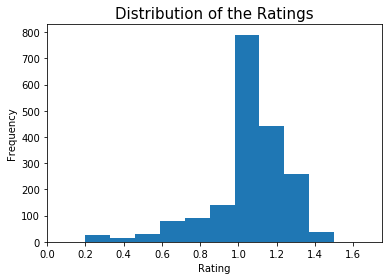

In [102]:
df.rating.plot(kind='hist', xlim=[0,1.75])
plt.title('Distribution of the Ratings', fontsize=15)
plt.xlabel('Rating')


The ratings are more frequent between 1 and 1.3.

Text(0,0.5,'Count')

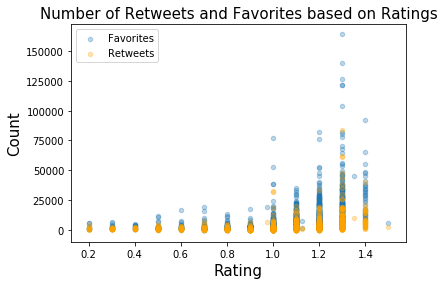

In [103]:
ax = df.plot.scatter(x='rating', y='favorite_count', alpha=0.3, label='Favorites');
df.plot.scatter(x='rating', y='retweet_count', color='Orange', alpha=0.3, label='Retweets', ax=ax);
plt.title('Number of Retweets and Favorites based on Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)

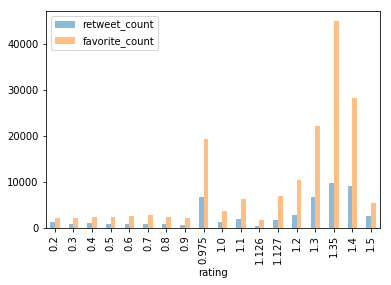

In [104]:
df.groupby('rating')['retweet_count','favorite_count'].mean().plot(kind='bar', alpha=0.5)

In [137]:
df[['rating','retweet_count','favorite_count']].corr(method = 'pearson')


,rating,retweet_count,favorite_count
rating,1.000000,0.305967,0.405575
retweet_count,0.305967,1.000000,0.930274
favorite_count,0.405575,0.930274,1.000000


In [105]:
df.breed.value_counts()[:15]

None                        289
Golden Retriever            153
Labrador Retriever          102
Pembroke                    92 
Chihuahua                   90 
Pug                         59 
Toy Poodle                  51 
Chow                        44 
Pomeranian                  42 
Samoyed                     38 
Malamute                    32 
Chesapeake Bay Retriever    29 
Cocker Spaniel              29 
French Bulldog              28 
Miniature Pinscher          24 
Name: breed, dtype: int64

Text(0,0.5,'Count')

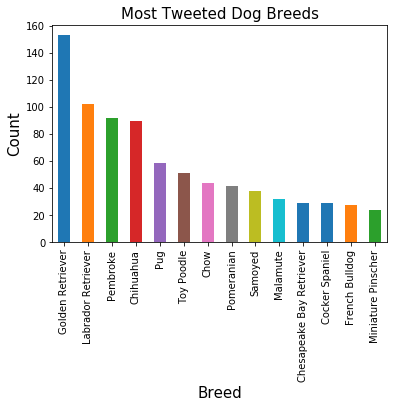

In [161]:
df.breed.value_counts()[1:15].plot(kind='bar')
plt.title('Most Tweeted Dog Breeds', fontsize=15)
plt.xlabel('Breed', fontsize=15)
plt.ylabel('Count', fontsize=15)

Text(0.5,0,'Breed')

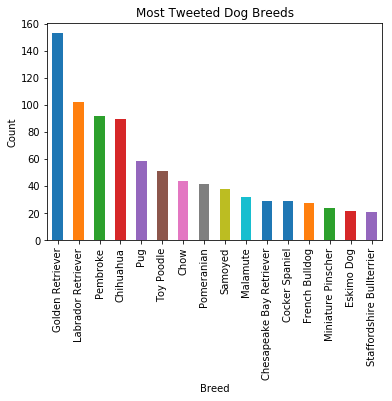

In [163]:
hot_breeds=df.groupby('breed').filter(lambda x: 200 > len(x) > 20)
hot_breeds['breed'].value_counts().plot(kind = 'bar')
plt.title('Most Tweeted Dog Breeds')
plt.ylabel('Count')
plt.xlabel('Breed')

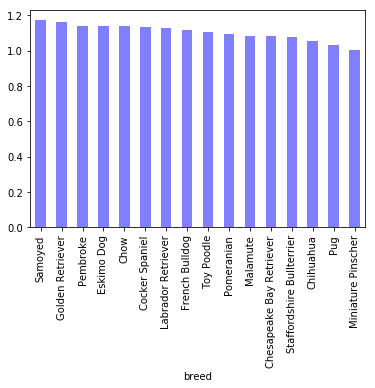

In [165]:
hot_breeds.groupby('breed')['rating'].mean().sort_values(ascending=False).plot(kind ='bar', color = 'Blue', alpha=0.5)